In [1]:
import os
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage


import pandas as pd
import numpy as np
import re
from fuzzywuzzy import fuzz
#import csv
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
newStopWords = ['page', 'a',  'b', 'c', 'd', 'e', 'f', 'g', 'h'] 
stop_words.extend(newStopWords)

pd.set_option('display.max_colwidth', -1)
import glob
import multiprocessing
import pickle
import gensim
from gensim.models import phrases
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import networkx as nx
import community #pip install python-louvain for community based partioning of graphs
import matplotlib.pyplot as plt
import logging
import time
start_time = time.time()

#packages release-
#gensim==3.5.0
#numpy==1.21.1
#scipy==1.7.0
#fuzzywuzzy==0.18.0
#pandas==1.1.5
#pdfminer==20191010
#gensim==3.8.3
##networkx==2.5.1

c:\users\ag89382\appdata\local\programs\python\python37\deepenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
c:\users\ag89382\appdata\local\programs\python\python37\deepenv\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
path1 = "C:/Nitesh/Projects/data/workflow_doc_search/workflow_pdfs/"
path2 = "C:/Nitesh/Projects/data/workflow_doc_search/workflow_text/"
path3 = "C:/Nitesh/Projects/data/workflow_doc_search/workflow_csv/"
path4 = "C:/Nitesh/Projects/data/workflow_doc_search/workflow_corpus/"
we_path= "C:/Nitesh/Projects/data/workflow_doc_search/workflow_we_model/"
we_vec_path = "C:/Nitesh/Projects/data/workflow_doc_search/vocab_wv/"
docs_embd_sim_path  = "C:/Nitesh/Projects/data/workflow_doc_search/doc_emb_sim/"

In [6]:

# [1] pdf to text files 
files1 = []
fnames = os.listdir(path1)
for name in fnames:
    if name.endswith('.pdf'):
        files1.append(name)
        
def convert(fname, pages= None):
    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams()) #laparams=LAParams(char_margin = 1000, all_texts=True, detect_vertical=False)) #char_margin = 0.5
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(fname, 'rb')
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return text


for i in range(0,len(files1)):
    fname = path1 + files1[i]
    text = convert(fname, pages= None)
    textFilename = path2 + files1[i] + ".txt"
    textFile = open(textFilename, "w", encoding = "utf-8")
    textFile.write(text) #write text to text file
    #print(textFilename)
    textFile.close()



In [5]:
#text cleaning - remove noisy words 
textfiles = []
fnames = os.listdir(path2)
for name in fnames:
    if name.endswith('.txt'):
        textfiles.append(name)
        
        
def text_clean(temp):
    text1 =pd.Series(temp)
    text11 = [string for string in text1 if string != ""]
    text1 = [re.sub('\S*@\S*\s?', '', sent) for sent in text11] # Remove emails
    text1 = [re.sub(r"http\S+", "", sent) for sent in text1] # remove urls
    text2 = [re.sub('\s+', ' ', sent) for sent in text1] # Remove newline character
    text3 = [re.sub("\'", "", sent) for sent in text2] # Remove distracting single quotes
    text4 = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in text3] # remove alphanumeric values
    text5 = [''.join(i for i in s if not i.isdigit()) for s in text4] # remove numbers
    text5 = [s.strip() for s in text5]
    text5 = [l.lower() for l in text5]
   
    return text5


noise = 'suggest changes document please contact epl practice leader'

unwanted_strings= {'',
 'page  of',
 'to suggest changes to this document please contact your epl or practice leader',
 'v'}  #'enter version code'  #'scanning troubleshooting v'



def clean_pdfconverted_text(filename, unwanted_strings, noise):
    #print(filename)
    data = pd.read_csv(path2 + filename, sep="\t", header=None, error_bad_lines=False)
    data.columns = ['text']
    data1 = list(data.text)
    data2 = [ele for ele in data1 if ele not in data1[0]] # data1[1:]
    data22= [ele for ele in data2 if ele not in data2[-3:]]
    
    temp= ''
    for i in data22:
        temp = temp + i
        
    temp1 = temp.split('.')
    tempcleaned = text_clean(temp1)
    tempcleaned1 = [ele for ele in tempcleaned if ele not in unwanted_strings] 
    
    corpus = [[word for word in doc.split()] for doc in tempcleaned1]
    corpus1 = [([i for i in doc if i not in stop_words]) for doc in corpus]
    corpus2 = [x for x in corpus1 if x]  # remove any blank string values
    text5_1 =  [' '.join(i) for i in corpus2]
    
    ind = []
    for i in range(0, len(text5_1)):
        temp = fuzz.token_set_ratio(text5_1[i], noise)  # remove noise
        if temp == 100:
            ind.append(i)
    
    for indexval in ind:
        text5_1[indexval] = text5_1[indexval].replace(noise, "")  # replace noise with ""
        
    for i in text5_1[:]:                    # replace if string contains only single word.
        if len(i.split()) == 1:
            text5_1.remove(i)     
            
    text5_1 = [x for x in text5_1 if x]
    
    textfile_write_path = path3 + filename + '.csv'
    my_df = pd.DataFrame(text5_1)
    my_df.to_csv(textfile_write_path, index=False, header=False)
    #print("\n"+ textfile_write_path + "\n")
    
    return text5_1
    
for i in range(0, len(textfiles)):
    clean_pdfconverted_text(textfiles[i], unwanted_strings, noise)


In [3]:
'prepare corpus of unigrams and bigrams using phrases.Phrases to extract meaningful bigram phrases'
files = []
fnames = os.listdir(path3)
for name in fnames:
    if name.endswith('.csv'): #'.pkl'
        files.append(name)
        

def concatenate_multiple_strings(filename):
    data = pd.read_csv(path3 + filename, header=None, error_bad_lines=False)
    data.columns = ['text']
    data1 = data.text.str.cat(sep=' ')
    corpus0 = data1.split()
    
    return corpus0
      

corpus = []
for f in files:
    temp = concatenate_multiple_strings(f)
    corpus.append(temp)

    

bigrams = phrases.Phrases(corpus, min_count=1, threshold=1)  # saturates at 2
#trigrams = phrases.Phrases(bigrams[list1], min_count = 2, threshold=1)   
#transformedcorpus1 = trigrams[bigrams[list1]]
unibigram_corpus = bigrams[corpus]
print("\nCorpus Vocab: \n", list(unibigram_corpus)[3])  #corpus vocab from document# 2
print("\nDocuments Length in the corpus:\n",len(list(unibigram_corpus)))

with open(path4 + 'corpus_of_bigrams.pkl' , 'wb') as f:
    pickle.dump(unibigram_corpus, f)


Corpus Vocab: 
 ['using', 'ambulatory_organizer', 'many', 'positions', 'ambulatory_organizer', 'landing', 'select', 'clicking', 'icon', 'labeled', 'ambulatory_organizer', 'day_view', 'displays', 'day', 'schedule', 'individual', 'resources', 'provider', 'location', 'depending', 'appointments', 'scheduled', 'first_time', 'log', 'need_set', 'resources', 'would_like', 'view_customize', 'display', 'day_view', 'sorting', 'hiding', 'rearranging', 'display', 'columns', 'colour', 'far', 'left', 'indicates', 'status', 'appointment', 'automatically', 'update', 'also', 'manually', 'updated', 'status', 'column', 'color', 'status', 'color', 'definition', 'light', 'blue', 'confirmed', 'appointment', 'medium', 'blue', 'checked', 'appointment', 'green', 'orange', 'brown', 'purple', 'yellow', 'seen', 'nurse', 'seen', 'physician', 'resident', 'seen', 'respiratory', 'therapist', 'seen', 'allied', 'health', 'see', 'next', 'dark_grey', 'checked', 'hover', 'pointer', 'patient_name', 'see_patient', 'name', '

In [6]:
'word embedding model training steps'

files1 = []
fnames = os.listdir(path4)
for name in fnames:
    if name.endswith('.pkl'):
        files1.append(name)
        
df1=pd.read_pickle(path4 + files1[0])
#list(df1)[0]

class MySentences(object):
    def __init__(self, pathname):
        self.pathname = pathname
 
    def __iter__(self):
        files=glob.glob(self.pathname+"*.pkl")
        for fname in files:
            transf_corpus = pd.read_pickle(fname)
            for c in transf_corpus:
                yield c
                
class LossLogger(CallbackAny2Vec):
    
    def __init__(self, loss_init,  we_path):  # mod_savepath
        self.epoch=0
        self.loss_init = 0
        #self.mod_savepath = mod_savepath  # to save output model
        self.we_path = we_path
        #os.makedirs(self.mod_savepath, exist_ok=True)
        os.makedirs(self.we_path, exist_ok=True)

        
    def on_epoch_end(self,model):
        loss=model.get_latest_training_loss()
        loss_actual = loss - self.loss_init # loss = cummulative loss; loss_init = cummulative loss till prev. step
        self.loss_init = loss  #initialise loss with cummulative value.
        
        print('Cumm and Actual Loss after epoch {}: {} & {}'.format(self.epoch, self.loss_init, loss_actual))
        #self.loss_init will keep on increasing in every iter whereas loss_actual should fall with each iter until 
        #it reaches minima.
    
        logging.info('Loss after epoch {}: {}'.format(self.epoch, self.loss_init, loss_actual))
        #logs = print(loss)
       
        with open(we_path + "wordembeddinglossinfo" + str(embeddingsize) + '_' + str(win_size) + '.txt', "a") as myfile:  # changed
            myfile.write(str(self.epoch) + "," + str(loss) + "," + str(loss_actual) + "\n")
        
     
            
        threshold = (loss_actual/self.loss_init)*100
        wordembedding_path = self.we_path
        wordembedding_path = wordembedding_path + 'wordembeddingmodel' + str(embeddingsize) + '_' + str(win_size)  # changed
        if(0 < threshold < 10):
            model.save(wordembedding_path)
           
            logging.info("Model saved for epoch"+ str(self.epoch) + str(self.loss_init) + str(loss_actual))
            #logs.save(wordembedding_path + 'logs.txt')
            #print('Time taken in epoch run:', time.time() - start_time)
        
        self.epoch=self.epoch+1
            
                

sentences = MySentences(path4)
print(len(list(sentences)))
loss_init  = 0
embeddingsize = 100 #model params
win_size =  10  #model params
model = Word2Vec(sentences, size= embeddingsize, window=win_size, alpha = 0.1, min_count=1, negative = 5, sg =1, compute_loss=True, iter =33, workers = 1, callbacks=[LossLogger(loss_init, we_path)])  #,pathname, foldername

52
Cumm and Actual Loss after epoch 0: 128619.875 & 128619.875
Cumm and Actual Loss after epoch 1: 252116.203125 & 123496.328125
Cumm and Actual Loss after epoch 2: 348092.3125 & 95976.109375
Cumm and Actual Loss after epoch 3: 399590.03125 & 51497.71875
Cumm and Actual Loss after epoch 4: 429988.03125 & 30398.0
Cumm and Actual Loss after epoch 5: 449150.15625 & 19162.125
Cumm and Actual Loss after epoch 6: 463857.59375 & 14707.4375
Cumm and Actual Loss after epoch 7: 475638.5 & 11780.90625
Cumm and Actual Loss after epoch 8: 484647.46875 & 9008.96875
Cumm and Actual Loss after epoch 9: 492922.3125 & 8274.84375
Cumm and Actual Loss after epoch 10: 500191.5625 & 7269.25
Cumm and Actual Loss after epoch 11: 506923.53125 & 6731.96875
Cumm and Actual Loss after epoch 12: 512631.53125 & 5708.0
Cumm and Actual Loss after epoch 13: 518131.0 & 5499.46875
Cumm and Actual Loss after epoch 14: 523227.90625 & 5096.90625
Cumm and Actual Loss after epoch 15: 527890.125 & 4662.21875
Cumm and Actual L

In [30]:
'Load Model and create mean embedding vector for each document from their respective vocab embeddings'

model1 = KeyedVectors.load(we_path + "wordembeddingmodel" + str(embeddingsize) + '_' + str(win_size), mmap='r')

'Get Model Vocabulary and Vocabulary Vectors'
model_vocab = list(model1.wv.vocab)
vocab_vectors =[model1.wv[i] for i in model_vocab]
print("\nModel Vocabulary:\n", model_vocab[0:50])  #100 model vocab tokens
print("\nCount of Vocab Vectors:\n", len(vocab_vectors))


doc_corpus = list(sentences)
print("\nLength of Documents in Corpus:\n", len(doc_corpus))


def find_mean_vector(model, doc_tokens, vocab):
    # remove out-of-vocabulary words
    words1 = [word for word in doc_tokens if word in vocab]
    if len(words1) >= 1:
        return np.mean(model.wv[words1], axis=0)
    else:
        return []


mean_vector = [find_mean_vector(model1, doc, model_vocab) for doc in doc_corpus] 
# list of embeddings each corresponding to each document. That is to say, 6 documents will have 6 embeddings.

with open(we_vec_path + 'mean_vector_list.pkl', 'wb') as f:
    pickle.dump(mean_vector, f)


Model Vocabulary:
 ['nursing', 'oxytocin', 'administration', 'induction', 'postpartum', 'review', 'order', 'orders_section', 'menu', 'open', 'medication_administration', 'wizard', 'tool_bar', 'scan_patient', 'wrist', 'band_scan', 'bag', 'ringers_lactate', 'vials', 'within', 'click_yellow', 'details', 'box', 'complete_required', 'elements', 'details_window', 'ensure_selected', 'correct', 'starting_dose', 'munit_min', 'chosen', 'site', 'infusion_site', 'ensure', 'document', 'witness', 'using_search', 'search', 'name_search', 'witnesses', 'last_name', 'first', 'name', 'necessary_select', 'name_list', 'clicking', 'clicking_ok', 'enter', 'last', 'click']

Count of Vocab Vectors:
 3082

Length of Documents in Corpus:
 52


In [8]:
'Import mean embedding vector picke file and map them to their corresponding document'
filenames = []
fnames = os.listdir(path1)
for name in fnames:
    if name.endswith('.pdf'):
        filenames.append(name)
filenames

zipped_list = list(zip(filenames, mean_vector))
df1 = pd.DataFrame(zipped_list, columns = ['filenames', 'mean_vector'])
df1.to_csv(we_vec_path +  'mean_embd_vec' + str(embeddingsize) + '_' + str(win_size) + '.csv', index=False, columns = ['filenames', 'mean_vector'])
' import existing document embeddings'

df1.iloc[0:5,]  # Top 5 rows documents and their mean embedding vector

,filenames,mean_vector
0,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,"[-0.6605233, -1.5572312, -1.1462492, 0.08165756, 0.8640354, -0.9243885, -1.5345117, -1.5779654, -0.46268296, -0.028245453, 0.09552947, 0.9137713, -2.7682638, -0.9890755, -1.2065302, -0.52634543, -2.8546145, 1.437578, -0.885912, -1.2708524, -1.368184, 3.8206074, 0.33245692, 1.9578118, -1.1574343, 1.0729952, 1.0526534, 1.389916, 2.1267893, -0.47981873, -2.1796858, 1.1779764, 2.840472, -0.3275671, 2.2366521, -0.22146216, 0.33086124, 0.015540904, -0.83433425, 2.3789618, 0.7038427, 0.31758153, -1.5921352, 1.0596828, -2.5853863, -0.57617384, -2.9399827, -1.3176417, 2.4041352, -2.3995986, -0.37077716, -0.87525284, -0.16156408, 0.8613176, 0.8801285, -0.000829593, -2.5929673, -0.78758067, -1.5120355, 2.8483934, -0.039873943, -1.1325012, 0.9118615, -0.5286365, -1.0403231, -1.3334459, -1.9953436, -0.5240711, 0.3380508, -0.27616322, 2.1526551, -0.7819107, 0.08496495, -0.80074966, -1.5229731, 2.8473935, -1.2469652, -2.6948433, -2.1932375, 1.7073836, -1.2687331, 2.1536403, -0.71198255, -3.0272727, 0.84458107, 0.55524313, -1.4866806, 0.53181726, 1.1693153, 0.30438408, -0.16788903, -0.89919364, -1.3937731, 0.033611268, 0.0032658805, -0.07875869, -2.9717836, 1.0867419, 1.3967113, 1.6666826]"
1,AIS - Threat Alert ED V1.2_1.2.pdf,"[-0.7208463, -1.4600621, -0.3390582, -1.0295384, 1.3253043, -0.8877303, -0.2596708, -0.27157947, -0.89460874, 0.18130997, -0.2816459, 0.114862904, -2.2500641, -1.0642277, 0.46874028, -0.42209673, -3.5250592, 1.9382058, -0.5725007, -0.70834744, -0.28489742, 3.2521043, -1.3857529, 1.3823253, -1.0590492, 0.9325109, 2.160873, 2.2519414, 0.55860656, 0.44113106, -1.0435194, 1.1461825, 1.5664561, 0.8703108, 3.1332605, 0.5849601, 0.8714478, 0.17755927, 0.04610506, 1.6754265, -0.33006695, -0.75064874, -2.5320194, 1.7312131, -1.4168911, -0.69651675, -3.0185733, -0.2981543, 2.319103, -2.2737365, -0.23754446, -0.8258953, -0.8951035, -0.039194815, 1.2186574, 0.17628494, -1.3890566, -2.3438299, -1.8821939, 2.185195, -0.8554334, 0.1538741, 0.0550851, -0.51193774, -0.7966019, -0.48321015, -2.8931198, 0.01624244, 0.85030687, -0.40946943, 2.1692734, -0.9562739, 0.95402396, -1.1047683, -0.7014433, 2.2282326, -1.1151096, -2.3852677, -2.6831234, 1.3522478, -0.45466158, 2.2688308, -0.6956666, -2.6448286, 1.5562038, -0.7666962, 0.6975211, -0.6918324, 1.1306899, 1.1370275, -0.015735757, -1.6325872, -1.0834476, 0.7919737, 1.2813579, 0.33786643, -3.0966966, 1.903721, 2.00742, 0.12514262]"
2,Allergies V1.2_2.0.pdf,"[-0.35029948, -1.7270728, -1.207535, 1.2278129, 1.3962966, 0.47844076, -1.4484706, -0.816632, -1.4962674, 0.5178245, 0.31779897, 0.54336935, -3.8582163, -0.52316487, -1.3186401, -0.47225797, -2.1213033, 1.545989, -0.95284706, -2.871036, 2.3951163, 4.3142266, 0.8253749, 1.7178856, -1.0090958, 1.5768288, 1.4410182, 1.6225315, 1.1051552, -1.1007904, -1.9441049, 1.9792409, 3.5622618, -0.4321117, 3.4108515, 0.27786246, 0.37341115, 0.8616424, -1.1333781, 1.9440963, 1.0477374, -0.40373164, -2.1922672, 1.0070133, -1.1437172, -0.7036626, -1.5609621, -1.9975843, 2.8991995, -1.3359789, -0.056145053, -0.4316403, 1.1873058, -0.5737144, 1.715444, -1.06813, -2.1534321, -1.473001, -0.7633572, 1.9968132, 0.38808239, -1.5087578, 0.7883338, -0.94748366, -1.4364668, -1.0554343, -1.955166, -0.6503633, 1.0183172, -0.7610398, 2.3040714, -1.0245577, -0.9474736, -0.36437774, -1.4921248, 2.8827763, -1.7160032, -2.6744053, -0.2467059, 1.0582405, 0.5896768, 3.131134, 1.0288733, -2.7333422, 0.6391441, -0.61419976, -2.4418638, 0.20630538, 0.9192986, -0.723841, -1.4533933, 0.3579935, -1.3001109, -0.57242787, 1.8305218, -1.1927395, -2.6271443, 3.0721915, 1.503893, -0.16705792]"
3,Ambulatory Organizer V1.2_1.0.pdf,"[-0.2249734, 0.24390964, -1.613144, -0.8345906, 0.7682959, -0.32275096, -1.7241516, -0.24075681, -1.2879909, 0.3852989, -0.40721694, 1.6890764, -2.7053974, -1.2610433, -0.60835516, -0.5169812, -2.562452, 1.4795357, -0.32409522, -0.9030471, -0.78832537, 3.768909, -0.56

In [9]:
files2= []
fnames = os.listdir(we_vec_path)
for name in fnames:
    if name.endswith('.pkl'):
        files2.append(name)


data = pd.read_pickle(we_vec_path + files2[0])  #read mean embeddings pickle file of documents
no_of_phrase = len(data)  # count of documents
embedding = list(data)  
model_embedding = np.reshape(embedding, (no_of_phrase, embeddingsize)) # matrix of shape (<no of docs>, <embedding size>)
print("\nDocument Emedding Matrix:\n", model_embedding)

print("\nShape of Embedding Matrix:\n", model_embedding.shape)


Document Emedding Matrix:
 [[-0.6605233  -1.5572312  -1.1462492  ...  1.0867419   1.3967113
   1.6666826 ]
 [-0.7208463  -1.4600621  -0.3390582  ...  1.903721    2.00742
   0.12514262]
 [-0.35029948 -1.7270728  -1.207535   ...  3.0721915   1.503893
  -0.16705792]
 ...
 [ 0.28536302 -1.0515647  -1.6180699  ...  0.9017294   1.8993223
   0.94861156]
 [ 0.12516613 -0.5570023  -1.7791352  ...  2.925719    1.678059
   0.43976438]
 [ 0.5623563  -0.27844843 -1.3612736  ...  1.1742173   1.1172646
   0.87510717]]

Shape of Embedding Matrix:
 (52, 100)


In [10]:
'Document embedding vector for the user input query(a word or a sentence)'

val = input("Enter string: ") 
print("\nInput Entered by User is :\n", val)
keywords = val.split()
print("\nInput tokens from input string :\n", keywords)

testwords = [word for word in keywords if word in model_vocab]
print("\nTest Document Tokens in model vocabulary are : \n", testwords)
testwords_meanvec = np.mean(model1.wv[testwords], axis=0)
testwords_meanvec1 = testwords_meanvec.reshape(1,embeddingsize) # shape of test vector (1,100)
print("\nTest Mean Embedding Vector is :\n", testwords_meanvec1)

Enter string: oxytocin administration required for postpartum

Input Entered by User is :
 oxytocin administration required for postpartum

Input tokens from input string :
 ['oxytocin', 'administration', 'required', 'for', 'postpartum']

Test Document Tokens in model vocabulary are : 
 ['oxytocin', 'administration', 'required', 'postpartum']

Test Mean Embedding Vector is :
 [[-0.61277825 -1.9875991  -1.3584492   0.94844085  0.5249562  -0.85501456
  -0.8766415  -2.1774433  -1.1523734  -1.0171657   0.05383386 -0.10983688
  -3.0592704  -0.9470565  -2.3120694   0.5156471  -3.0078826   1.5303786
  -0.17051324 -2.0953565  -0.8188358   3.1780977   1.2981117   2.7490678
  -1.135522    1.2367674   0.96505606  1.2486295   1.0841215  -1.4663582
  -1.8064668   1.0570011   4.0375743  -0.03873122  2.0504618  -0.08783184
   0.46028072 -0.73776114 -0.71977454  0.7595585   0.7846327   0.65593415
  -1.8861959   0.9920293  -1.8894167  -1.6075484  -2.48581    -1.3654522
   2.3943875  -3.0323977   0.4309

In [13]:
'Explore the relevant document to the user input query using cosine similarity metric'
cosine_sim_matrix = cosine_similarity(model_embedding, testwords_meanvec1)


zipped_list1 = list(zip(filenames, cosine_sim_matrix))
cosine_metric = pd.DataFrame(zipped_list1, columns = ['filenames', 'cos_sim_score'])
cosine_metric['cos_sim_score'] = cosine_metric['cos_sim_score'].astype(float)
#print("\nScore matrix of documents for user query: \n", cosine_metric)



recommendations = cosine_metric.nlargest(3, ['cos_sim_score'])
print("\nTop three recommended documents pertaining to user search:\n")
recommendations
''''
Recommendation on the user query-  oxytocin administration required for postpartum 
is Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf, which is good.
'''
##Recommendation holds valid but there are opportunities to improve it.


Top three recommended documents pertaining to user search:



,filenames,cos_sim_score
0,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,0.902667
27,IPAC Progress Note Dynamic Documentation - V1.2_1.0.pdf,0.892337
35,Nursing Phased Depot Initiation V1.2_1.0.pdf,0.875639


#### Similarity among document embeddings i.e. similarity among documents embeddings stored in variable: model_embedding  -

In [14]:
'find the similarity between document embeddings '

doc_sim_matrix = cosine_similarity(model_embedding, model_embedding)
#print("\nDocument Embeddings Similarity Matrix:\n", doc_sim_matrix) #shape len(documents)*len(documents) 

column_names = list(filenames)
row_names = list(filenames)
doc_sim_df = pd.DataFrame(doc_sim_matrix, columns=column_names, index=row_names)
print("\nEmbedding Similarity Matrix is : \n", doc_sim_df.iloc[0:10,0:10]) # top few rows and columns of matrix
with open(docs_embd_sim_path + "doc_sm_mat.pkl", 'wb') as f:
    pickle.dump(doc_sim_df, f)


Embedding Similarity Matrix is : 
                                                                  Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf  \
Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf  1.000000                                                          
AIS - Threat Alert ED V1.2_1.2.pdf                               0.853444                                                          
Allergies V1.2_2.0.pdf                                           0.839842                                                          
Ambulatory Organizer V1.2_1.0.pdf                                0.907886                                                          
Attending a Delivery V1.2_1.0.pdf                                0.897641                                                          
Best Possible Medication History - Emergency V1.2_1.0.pdf        0.813988                                                          
Best Possible Medication History - Inpat

In [15]:
'Find the linked documents with a similarity threshold of 0.85'

embd_files = []
fnames = os.listdir(docs_embd_sim_path)
for name in fnames:
    if name.endswith('.pkl'):
        embd_files.append(name)
embd_files

def clustering_on_docs_embedding(filename):
    print("filename is:", str(filename))
    df1 = pd.read_pickle(docs_embd_sim_path + filename)
    #df1 = pd.read_pickle(output_pathname + files1[0]) 
    arr = df1.values
    index_names = df1.index
    col_names = df1.columns
    R,C = np.where(np.triu(arr))  # consider upper triangle val = lower triangle val
    out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
    
    
    def cluster(docs, out_df):
        phr = out_df.loc[(out_df['A'].isin(list(set(docs)))) & (out_df['C'] >= 0.85)]['B']
        return phr


    out_df = pd.DataFrame(out_arr, columns = ['A', 'B', 'C']) 
    #out_df['is_same'] = [bool(i==j) for i, j in zip(out_df['A'], out_df['B'])]
    #out_df = out_df[out_df['is_same'] != True]
    vocab_words = out_df['A'].unique()    # initial vocab  # update in each iter
    
    # 0th vocab word 
    cn = out_df.loc[(out_df['A'].isin(vocab_words[[0]])) & (out_df['C'] >= 0.85)]['B']  # connecting nodes for 1st vocab word
    
    n= int((out_df.shape[0])/2)

    'cluster 1'
    for i in range(n):
        phrval = cluster(cn, out_df)
        #cn = phrval
        if len(phrval) != len(cn): # saturation condition
            cn = phrval
            #print(i)
        else:
            break

    clust1 = set(phrval) 
    vocab_words = np.array(list(set(vocab_words) - set(phrval)))  # 1 update vocab.(vert.)
    z = set()
    z = z.union(clust1)


    'function to obtain other clusters'
    def find_clusters(z, vocab_words, out_df):
        out_df = out_df.loc[~out_df['B'].isin(z)]  # input
        cn = out_df.loc[(out_df['A'].isin(vocab_words[[0]])) & (out_df['C'] >= 0.85)]['B']
    
        for i in range(n):
            phrval = cluster(cn, out_df)
            if len(phrval) != len(cn):
                cn = phrval
                print(i)
            else:
                break
        clust = set(phrval)
        z = z.union(clust)  # input
        vocab_words = np.array(list(set(vocab_words) - set(phrval))) #input
        
        return out_df, clust, z, vocab_words

    'initialize a dictionary with cluster 1 output'
    clust_dict = defaultdict(list) 
    clust_dict[0].append(clust1)
    
    'obtain other cluster, reduce vocab to zero and increase cluster values to total vocab'
    for i in range(1,n):
        out_df1, clust1, z1, vocab_words1 = find_clusters(z, vocab_words, out_df)
        if len(vocab_words1) != 0:
            clust_dict[i].append(clust1)
            z = z1
            vocab_words = vocab_words1
            out_df = out_df1
            print(i)
        else:
            clust_dict[i].append(clust1)
            vocab_words = vocab_words1
            z=z1
            break
    

    
    #with open(output_pathname + str(filename), 'wb') as f:
     #   pickle.dump(clust_dict, f)
    return clust_dict


clustering_on_docs_embedding(embd_files[0])

filename is: doc_sm_mat.pkl
1
2
0
3
0
4


defaultdict(list,
            {0: [{'AIS - Threat Alert ED V1.2_1.2.pdf',
               'Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf',
               'Ambulatory Organizer V1.2_1.0.pdf',
               'Attending a Delivery V1.2_1.0.pdf',
               'Blood Administration V1.2_2.0.pdf',
               'Capacity Assessment V1.2_1.0.pdf',
               'Clinical Notes - Allied Health V1.2_1.1.pdf',
               'Clinical Notes - Outpatient Dietitian V1.2_1.1.pdf',
               'Clinical Notes - Outpatient Nurse V1.2_1.1.pdf',
               'Common Icons V1.2_1.0.pdf',
               'Creating Lists & Adding Patients V1.2_2.0.pdf',
               'Customize iView V1.2_2.0.pdf',
               'Discharge for NICU and Pediatrics V1.2_1.0.pdf',
               'ECG Match & Unmatch Studies V1.2_1.1.pdf',
               'FetaLink - Annotations V1.2_2.0.pdf',
               'FetaLink - Association and Finalizing Checklist V1.2_1.0.pdf',
               'FetaLink - Fi

In [16]:
"Find similar documents for each document which are nodes and their cosine similarity with other documents as edges"
"Using the community based"

df1 = pd.read_pickle(docs_embd_sim_path + "doc_sm_mat.pkl")
#df1 = pd.read_pickle(output_pathname + files1[0]) 
arr = df1.values
index_names = df1.index
col_names = df1.columns
R,C = np.where(np.triu(arr))  # consider upper triangle val = lower triangle val
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))

out_df = pd.DataFrame(out_arr, columns = ['A', 'B', 'C']) 
out_df['is_same'] = [bool(i==j) for i, j in zip(out_df['A'], out_df['B'])]
out_df = out_df[out_df['is_same'] != True]
print("\nBetween Documents Similarity:\n")

out_df = out_df[out_df['C'] > 0.85]  #having similarity score > 0.85
out_df


Between Documents Similarity:



,A,B,C,is_same
1,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,AIS - Threat Alert ED V1.2_1.2.pdf,0.853444,False
3,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,Ambulatory Organizer V1.2_1.0.pdf,0.907886,False
4,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,Attending a Delivery V1.2_1.0.pdf,0.897641,False
7,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,Blood Administration V1.2_2.0.pdf,0.87662,False
8,Administering Oxytocin for Induction or Postpartum V1.2_1.0.pdf,Capacity Assessment V1.2_1.0.pdf,0.899604,False
...,...,...,...,...
1366,Sedation Procedure for Medications Administration V1.2_2.1.pdf,Transfer of Information - Handoff V1.2_1.1.pdf,0.895122,False
1367,Sedation Procedure for Medications Administration V1.2_2.1.pdf,Workstation on Wheels and Medication Administration FAQ V1.2_1.0.pdf,0.926696,False
1373,Titratable Drips V1.2_1.0.pdf,Transfer of Information - Handoff V1.2_1.1.pdf,0.899496,False
1374,Titratable Drips V1.2_1.0.pdf,Workstation on Wheels and Medication Administration FAQ V1.2_1.0.pdf,0.8618,False


In [17]:
'get the community based clusters to find the relations between nodes'
nodes = list(set(out_df['A']).union(set(out_df['B'])))
edges = list(zip(out_df['A'], out_df['B']))
wt_edges = list(zip(out_df['A'], out_df['B'], out_df['C']))

#print("\nNodes are \n {} and \n\n Weighted Edges are \n {}".format(nodes, wt_edges))

print("\n There are {} Nodes and {} Edges".format(len(nodes), len(edges)))


 There are 50 Nodes and 816 Edges


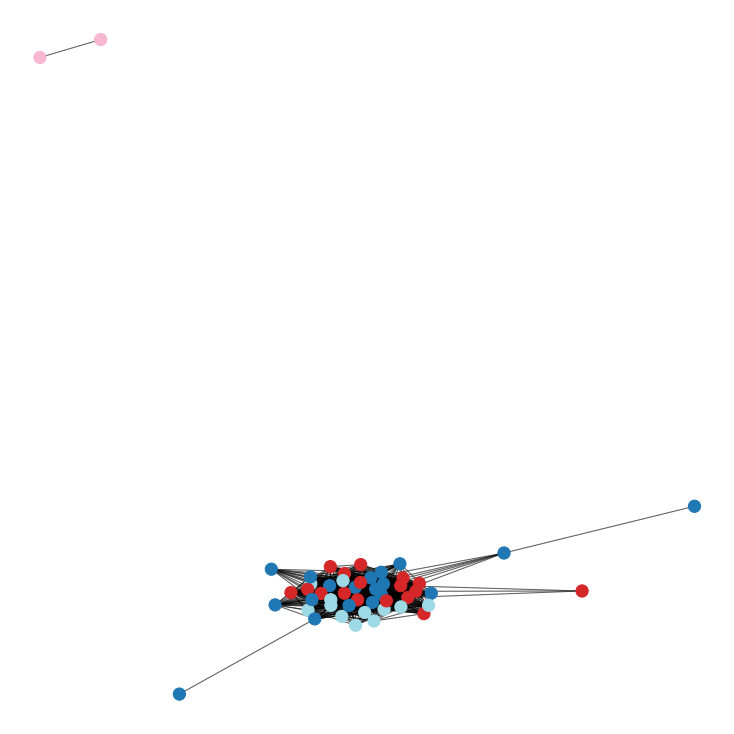

In [26]:
G = nx.Graph()
G.add_nodes_from(nodes) #input is list of nodes
G.add_edges_from(edges) #input is list of edges
G.add_weighted_edges_from(wt_edges, weight= 0.85)

partition = community.best_partition(G, random_state=7)
modularity = community.modularity(partition, G, weight='weight')
#The higher the modularity, the denser within-cluster connections are and the sparser the inter-cluster connections are.

pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)
nx.draw_networkx_edges(G, pos, alpha = 0.5)

In [27]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']
frame_clust

,Title,Cluster
0,ECG Match & Unmatch Studies V1.2_1.1.pdf,0
1,Customize iView V1.2_2.0.pdf,0
2,Result Copy & Related Record - Singleton V1.2_2.0.pdf,2
3,Medication Administration V1.2_2.0.pdf,0
4,Inpatient Discharge Documentation V1.2_2.0.pdf,0
5,Proxy a Patient List V1.2_2.1.pdf,3
6,Multi Patient Task List - Setting Up V1.2_3.0.pdf,3
7,FetaLink - Association and Finalizing Checklist V1.2_1.0.pdf,3
8,Group Note V1.2_1.1.pdf,0
9,Best Possible Medication History - Emergency V1.2_1.0.pdf,0


In [ ]:
'References-'


## word2 vec:
#https://rare-technologies.com/word2vec-tutorial/
#https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
#https://israelg99.github.io/2017-03-23-Word2Vec-Explained/
#http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
#https://medium.com/analytics-vidhya/combining-word-embeddings-to-form-document-embeddings-9135a66ae0f
#https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1


#community based detection:
#https://www.python-course.eu/networkx.php
#http://snap.stanford.edu/class/cs224w-2016/projects/cs224w-58-final.pdf
#https://link.springer.com/article/10.1007/s10994-020-05882-8
#https://arxiv.org/pdf/2104.09439.pdf
#https://arxiv.org/abs/0803.0476   
#https://www.sciencedirect.com/topics/computer-science/community-detection
#https://arxiv.org/ftp/arxiv/papers/1512/1512.07827.pdf
#https://python-louvain.readthedocs.io/en/latest/api.html
#https://readthedocs.org/projects/python-louvain/downloads/pdf/latest/
